프로젝트 개요

안녕하세요. 팀 빅-맨입니다. 저희는 미국에 상장되어있는 기업에 대한 다음날 수정 종가예측을 목표로 잡았습니다. 여기서 다음날은 보유하고 있는 데이터의 마지막날을 기준으로 합니다.
예시코드는 엔디비아 기업을 '2013-09-28' 부터 현재 날짜까지 진행하였습니다. 티커가 있는 기업이라면, 모두 예측분석이 가능합니다. 데이터 수집량도 변경할 수 있습니다.

일반적으로 주가예측을 하기 위해선 해당 기업에 대한 기술적 분석과 기본적 분석을 병행해야 합니다.
기술적 분석이란 과거의 주가나 거래량 등 주가를 활용한 분석을 말하며, 기본적 분석이란 주식 가치에 영향을 주는 기업의 내적 요인을 활용한 분석을 말합니다.

기존 기술적 분석에 기반한 주가예측모델의 한계를 넘기 위해, 우리는 기본적 분석에 대한 주가예측모델을 각각 진행하고, XGBoost를 이용한 Stacking 모델을 통해 최종 예측 모델을 만들었습니다.
이를 통해 상대적으로 과적합 문제를 해결하며 예측력이 높은 결과를 도출했습니다.

데이터 수집:
재무제표를 제외한 데이터들은 모두 오픈소스 라이브러리를 통해 수집되었으며, 재무제표는 크롤링을 통해 진행되었습니다.

1. 기술적 분석 지표 
- (야후 파이낸스)에 기반한, 기간동안의 open, high, low, close, Adj Close, Volume
- 보조지표: SMA(단순 이동평균), EMA(지수 이동평균), Double Bollinger Bands, RSI, MACD, OVD

2. 기본적 분석 지표: 경제, 산업, 기업 분석의 지표들로 구성되었습니다.
- 경제지표: (FRED)에 기반한 DGS(미국 국채 금리), U.S. long-short interest rate(장단기 금리차), VIX(변동성 지수), Unemployment Rate (실업률), CPI(소비자 가격 지수), Federal funds rate (미 연방 기준 금리), GDP(국내 총생산)
- 산업지표: (FinanceDataReader)에 기반한 Dow Jones, NASDAQ, S&P500, Russell 2000, 해당 티커의 GICS sector에 기반한 ETF 주가 (출처: 야후 파이낸스 )
- 기업지표: (https://stockanalysis.com/stocks/nvda/financials/?p=quarterly)에 기반된 재무제표 크롤링 - Income (손익계산서), Balance(대차대조표), Cash(현금흐름표), Ratio Statement(재무 비율표)

변수 선택 기준: 해당 기업의 수정종가와 상관관계가 0.9 이상인 변수들이 선택되었습니다.

일부 기본적 분석 지표들은 분기별로 업데이트됩니다. 데이터 부족 현상을 해결하기 위해 선형보간법과 Holt-Winter ES 기법을 사용하였습니다. 

데이터 분석: 
1. 시계열분석을 효과적으로 하기 위해 기술적 분석과 기본적 분석은 LSTM 딥러닝 모델을 사용했습니다.
    -> 이때 기술적분석은 과적합이 필수적으로 생기고, 기본적분석은 성능이 그리 높지 않습니다.
2. 두 모델을 통해 얻은 각 예측값들을 새로운 인풋으로 사용하는 Stacking 메타 모델을 사용했습니다.
    -> XGBoost를 사용했으며, 모든 기업에 대한 정확도를 높이기 위해 GridSearchCV 방법을 사용하여 최적의 파라미터 조합을 찾습니다.

3. 학습된 메타모델과 LSTM 모델의 예측값을 이용하여 실제 다음날 주가 예측을 진행하였습니다.

## Import Libraries

In [1]:
import ta
import requests
import numpy as np
import pandas as pd
import yfinance as yf
import FinanceDataReader as fdr
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import seaborn as sns
from yahooquery import Ticker
from fredapi import Fred
from datetime import datetime
from bs4 import BeautifulSoup
from pandas_datareader import data as pdr
from statsmodels.tsa.holtwinters import ExponentialSmoothing

import datetime as dt
import tensorflow as tf
import matplotlib.dates as mdates
import xgboost as xgb
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, learning_curve
from keras.regularizers import L1L2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings

warnings.filterwarnings('ignore', category=UserWarning)

today = datetime.today().strftime('%Y-%m-%d')

## 0. 주가예측을 위한 범위 설정
주가예측을 진행하고 싶은 상장회사의 티커와, 시작일과 종료일을 지정해야 합니다.

이때 티커는 소문자로 입력해주어야 합니다.
또한, 시작일은 가급적 재무제표의 데이터를 높이기 위해 2013년 9월 이후로 해주는 것이 좋습니다.
만약 종료일을 오늘 날짜로 하고 싶다면, 종료일에 today만 입력해도 됩니다.

In [2]:
ticker = 'nvda' 
start_date = '2013-09-28'
end_date = today

# 데이터 준비

# 1. Technical data - 주가 데이터 수집 및 보조지표 추가

In [4]:
stock_df = yf.download(ticker, start = start_date, end = end_date)

## 1.1. Simple Moving Average (SMA)
stock_df['MA5'] = stock_df['Adj Close'].rolling(window=5).mean()        # 5일 SMA
stock_df['MA20'] = stock_df['Adj Close'].rolling(window=20).mean()      # 20일 SMA
stock_df['MA60'] = stock_df['Adj Close'].rolling(window=60).mean()      # 60일 SMA
stock_df['MA120'] = stock_df['Adj Close'].rolling(window=120).mean()    # 120일 SMA

## 1.2. Exponential Moving Average (EMA)
stock_df['EMA5'] = stock_df['Adj Close'].ewm(span=5, adjust=False).mean()       # 5일 EMA
stock_df['EMA20'] = stock_df['Adj Close'].ewm(span=20, adjust=False).mean()     # 20일 EMA
stock_df['EMA60'] = stock_df['Adj Close'].ewm(span=60, adjust=False).mean()     # 60일 EMA
stock_df['EMA120'] = stock_df['Adj Close'].ewm(span=120, adjust=False).mean()   # 120일 EMA

## 1.3. Double Bollinger Bands indicator

# Central Line (20-day moving average)
stock_df['BOL_AVG'] = ta.volatility.bollinger_mavg(stock_df['Adj Close'])

# Double Bollinger Bands
stock_df['BOL_H1'] = stock_df['BOL_AVG'] + 2 * stock_df['Adj Close'].rolling(window=20).std()
stock_df['BOL_L1'] = stock_df['BOL_AVG'] - 2 * stock_df['Adj Close'].rolling(window=20).std()
stock_df['BOL_H2'] = stock_df['BOL_AVG'] + stock_df['Adj Close'].rolling(window=20).std()
stock_df['BOL_L2'] = stock_df['BOL_AVG'] - stock_df['Adj Close'].rolling(window=20).std()

## 1.4. Relative Strength Index (RSI)
stock_df['RSI'] = ta.momentum.rsi(stock_df['Adj Close'])

## 1.5. Moving Average Convergence Divergence (MACD)
stock_df['MACD'] = ta.trend.macd(stock_df['Adj Close'])
stock_df['MACD_SIGNAL']= ta.trend.macd_signal(stock_df['Adj Close'])

## 1.6. On-Balance Volume (OBV)
stock_df['OBV'] = ta.volume.on_balance_volume(stock_df['Adj Close'], stock_df['Volume'])

stock_df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,MA5,MA20,MA60,MA120,...,EMA120,BOL_AVG,BOL_H1,BOL_L1,BOL_H2,BOL_L2,RSI,MACD,MACD_SIGNAL,OBV
Date,,,,,,,,,,,,,,,,,,,,,
2013-09-30,3.8550,3.9175,3.8325,3.8900,3.650517,22664000,NaN,NaN,NaN,NaN,...,3.650517,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22664000
2013-10-01,3.8950,3.9125,3.8650,3.8875,3.648172,22697600,NaN,NaN,NaN,NaN,...,3.650478,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-33600
2013-10-02,3.8475,3.9000,3.8475,3.8850,3.645825,16203600,NaN,NaN,NaN,NaN,...,3.650402,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-16237200
2013-10-03,3.8875,3.9225,3.8275,3.8450,3.608288,43676800,NaN,NaN,NaN,NaN,...,3.649705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-59914000
2013-10-04,3.8400,3.9300,3.8300,3.8975,3.657556,24622800,3.642072,NaN,NaN,NaN,...,3.649835,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-35291200


# 2. Fundamental data - 경제지표 불러오기

In [5]:
adj_close_df = stock_df[['Adj Close']]

## 2.1. U.S. Treasury bond yields 
fred = Fred(api_key = '4c55d0ee6170369793707da4cba1b7be')
dgs2 = fred.get_series('DGS2', observation_start=start_date, observation_end=end_date)      # 2년 DGS
dgs5 = fred.get_series('DGS5', observation_start=start_date, observation_end=end_date)      # 5년 DGS
dgs10 = fred.get_series('DGS10', observation_start=start_date, observation_end=end_date)    # 10년 DGS

DGS = pd.concat([dgs2, dgs5,dgs10], axis=1)
DGS.columns = ['2-year', '5-year', '10-year']
DGS.index.name = 'Date'

## 2.2. U.S. long-short interest rate spread (10-year & 2-year)
T10Y2Y = fdr.DataReader('FRED:T10Y2Y', start_date, end_date)
T10Y2Y.index.name = 'Date'

## 2.3. Volatility Index (VIX)
VIX = fdr.DataReader('FRED:VIXCLS', start_date, end_date)
VIX.index.name = 'Date'

## 2.4. Unemployment Rate
Unemployment_Rate = fdr.DataReader('FRED:UNRATE', start_date, end_date)
Unemployment_Rate.index.name = 'Date'

## 2.5. Consumer Price Index (CPI)
CPI = fdr.DataReader('FRED:CPIAUCSL', start_date, end_date)
CPI.index.name = 'Date'

## 2.6. Federal funds rate
FEDFUNDS = fdr.DataReader('FRED:FEDFUNDS', start_date, end_date)
FEDFUNDS.index.name = 'Date'

## 2.7. Gross Domestic Product (GDP)
GDP = pd.DataFrame(fred.get_series('GDP',observation_start=start_date, observation_end = end_date),columns=['GDP'])
GDP.index.name = 'Date'

## Interpolation and Holt-Winters' Exponential Smoothing for Monthly Data

# Linear interpolation up to the last date of the data
econ_month_df = Unemployment_Rate.join([CPI, FEDFUNDS], how='left')
itp_df = econ_month_df.resample('D').asfreq()
last_valid_indices = {column: itp_df[column].last_valid_index() for column in itp_df.columns}

for column in itp_df.columns:
    last_index = last_valid_indices[column]
    itp_df[column].loc[:last_index] = itp_df[column].loc[:last_index].interpolate(method='linear') # using linear method

# Holt-Winters' Exponential Smoothing: Forecasting from the last date in provided data to the desired End Date
forecast_steps = (pd.to_datetime(end_date) - itp_df.last_valid_index()).days
forecast_df = pd.DataFrame(index=pd.date_range(itp_df.last_valid_index() + pd.Timedelta(days=1), end_date))

for column in itp_df.columns:   
    data_to_fit = itp_df[column].dropna() # 마지막 유효한 값까지의 데이터만 사용
    model = ExponentialSmoothing(data_to_fit, trend='add', seasonal=None, seasonal_periods=12).fit()
    forecast = model.forecast(steps=forecast_steps)
    forecast_df[column] = forecast
    
daily_econ = pd.concat([itp_df, forecast_df])

## Interpolation and Holt-Winters' Exponential Smoothing for Quarterly Data 

# Linear interpolation up to the last date of the data
itp_df = GDP.resample('D').asfreq()
last_valid_index = itp_df['GDP'].last_valid_index()
itp_df['GDP'] = itp_df['GDP'].interpolate(method='linear').loc[:last_valid_index] # using linear method

# Holt-Winters' Exponential Smoothing: Forecasting from the last date in provided data to the desired End Date
forecast_steps = (pd.to_datetime(end_date) - itp_df.last_valid_index()).days
data_to_fit = itp_df['GDP'].dropna()
model = ExponentialSmoothing(data_to_fit, trend='add', seasonal=None, seasonal_periods=4).fit()
forecast = model.forecast(steps=forecast_steps)
forecast_df = pd.DataFrame(forecast, columns=['GDP'], index=pd.date_range(itp_df.last_valid_index() + pd.Timedelta(days=1), end_date))

daily_gdp = pd.concat([itp_df, forecast_df])
daily_econ = daily_econ.join([daily_gdp], how='left')

# Merge into economic data
econ_df = adj_close_df.join([DGS, T10Y2Y, VIX], how='left')
econ_df = econ_df.join([daily_econ], how='left')

econ_df.head()

,Adj Close,2-year,5-year,10-year,T10Y2Y,VIXCLS,UNRATE,CPIAUCSL,FEDFUNDS,GDP
Date,,,,,,,,,,
2013-09-30,3.650517,0.33,1.39,2.64,2.31,16.60,7.200000,233.664833,0.089667,17189.430076
2013-10-01,3.648172,0.33,1.42,2.66,2.33,15.54,7.200000,233.669000,0.090000,17192.019000
2013-10-02,3.645825,0.31,1.38,2.63,2.32,16.60,7.190323,233.682903,0.089677,17192.081163
2013-10-03,3.608288,0.33,1.36,2.62,2.29,17.67,7.180645,233.696806,0.089355,17192.143326
2013-10-04,3.657556,0.33,1.41,2.66,2.33,16.74,7.170968,233.710710,0.089032,17192.205489


# 3. Fundamental data - 산업지표 불러오기

In [6]:
## 3.1. Load major stock indices
yf.pdr_override() 
df = pdr.get_data_yahoo("^DJI", start=start_date, end=end_date) # Dow Jones
df1 = pdr.get_data_yahoo("NDAQ", start=start_date, end=end_date) # NASDAQ
df2 = pdr.get_data_yahoo("^SPX", start=start_date, end=end_date) # S&P500
df3 = pdr.get_data_yahoo("^RUT", start=start_date, end=end_date) # Russell 2000

# Rename Columns
df.rename(columns={'Adj Close': 'DJI Adj Close', 'Volume': 'DJI Volume'}, inplace=True) 
df1.rename(columns={'Adj Close': 'NDAQ Adj Close', 'Volume': 'NDAQ Volume'}, inplace=True)
df2.rename(columns={'Adj Close': 'SPX Adj Close', 'Volume': 'SPX Volume'}, inplace=True)
df3.rename(columns={'Adj Close': 'RUT Adj Close', 'Volume': 'RUT Volume'}, inplace=True)

# Select columns
df = df[['DJI Adj Close', 'DJI Volume']] 
df1 = df1[['NDAQ Adj Close', 'NDAQ Volume']]
df2 = df2[['SPX Adj Close', 'SPX Volume']]
df3 = df3[['RUT Adj Close', 'RUT Volume']]

Index_data = pd.concat([df, df1, df2, df3], axis=1, join='outer')
Index_data = Index_data.join(stock_df['Adj Close'], how='left')

## 3.2. "Industry Sector data based on ETF
sectors = {
    "VDE": "Energy",                 # Vanguard Energy ETF
    "MXI": "Materials",              # iShares Global Materials ETF
    "VIS": "Industrials",            # Vanguard Industrials ETF
    "VCR": "Consumer Cyclical",      # Vanguard Consumer Discretionary ETF
    "XLP": "Consumer Staples",       # Consumer Staples Select Sector SPDR Fund
    "VHT": "Health Care",            # Vanguard Healthcare ETF
    "XLF": "Financials",             # Financial Select Sector SPDR Fund
    "VGT": "Information Technology", # Vanguard Information Technology ETF
    "VOX": "Communication Services", # Vanguard Communication Services ETF
    "XLU": "Utilities",              # Utilities Select Sector SPDR Fund
    "VNQ": "Real Estate"             # Vanguard Real Estate Index Fund
}
sector_data = {}

# Load Adj Close and Volumes for the ETF industry sector
for sector, sector_name in sectors.items():
    data = yf.download(sector, start=start_date, end=end_date)
    data.rename(columns={
        'Adj Close': f'{sector_name} Adj Close',
        'Volume': f'{sector_name} Volume'
    }, inplace=True) 
    sector_data[sector] = data[[f'{sector_name} Adj Close', f'{sector_name} Volume']]
    
ETF = pd.concat(sector_data.values(), axis=1)

# Matching the adjusted closing prices and trading volumes for the ETF industry sector associated with the entered ticker's sector
sector = yf.Ticker(ticker).info.get('sector', None)
sector_columns = [col for col in ETF.columns if sector in col] 
sector_df = ETF[sector_columns]

# Merge into industry data
Industry_df = Index_data.merge(sector_df, on="Date", how="inner")


Industry_df.head()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

,DJI Adj Close,DJI Volume,NDAQ Adj Close,NDAQ Volume,SPX Adj Close,SPX Volume,RUT Adj Close,RUT Volume,Adj Close,Information Technology Adj Close,Information Technology Volume
Date,,,,,,,,,,,
2013-09-30,15129.669922,122330000,9.072846,2811900,1681.550049,3308630000,1073.790039,3308630000,3.650517,72.614685,380600
2013-10-01,15191.700195,82460000,9.151962,3609900,1695.000000,3238690000,1087.430054,3238690000,3.648172,73.388535,160200
2013-10-02,15133.139648,86090000,9.149134,3131400,1693.869995,3148600000,1082.550049,3148600000,3.645825,73.415504,350700
2013-10-03,14996.480469,91300000,9.129357,3960000,1678.660034,3279650000,1070.900024,3279650000,3.608288,72.641716,216800
2013-10-04,15072.580078,75100000,9.296066,4943100,1690.500000,2880270000,1078.250000,2880270000,3.657556,73.136581,456100


# 4. Fundamental data - 기업 재무제표 불러오기

In [7]:
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.82 Safari/537.36'
}

## 4.1. INCOME STATEMENT
url = f"https://stockanalysis.com/stocks/{ticker}/financials/?p=quarterly" 
response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.content, 'html.parser')
element_tables = soup.select("table[data-test='financials']")

Income_df = pd.read_html(str(element_tables))[0] 
Income_df.to_csv(ticker+'.csv', index=False)

FS_Income = Income_df.transpose()
FS_Income.columns = FS_Income.iloc[0]
FS_Income = Income_df.set_index("Quarter Ended").transpose()
FS_Income.index.name = "Date"
FS_Income.to_csv(ticker+'.csv', index=True, encoding='euc-kr')
FS_Income = FS_Income.iloc[:-1, :]

# Convert string to numeric type
for column in FS_Income.columns:
    if FS_Income[column].dtype == 'object':
        FS_Income[column] = FS_Income[column].apply(lambda x: float(x) if '-' in x and x[1:].isdigit() else x)  # Converting strings with numbers after '-'
        if FS_Income[column].dtype == 'object' and FS_Income[column].str.contains('%').any():
            FS_Income[column] = FS_Income[column].apply(lambda x: float(x.replace('%', '')) / 100 if '%' in x else x)   # Converting strings with a percentage sign
        FS_Income[column] = pd.to_numeric(FS_Income[column], errors='coerce')   # Converting other strings to numbers
        
## 4.2. RATIO STATEMENT
url = f"https://stockanalysis.com/stocks/{ticker}/financials/ratios/?p=quarterly" 
response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.content, 'html.parser')
element_tables = soup.select("table[data-test='financials']")

Ratio_df = pd.read_html(str(element_tables))[0]
Ratio_df.to_csv(ticker+'.csv', index=False)

FS_Ratio = Ratio_df.transpose()
FS_Ratio.columns = FS_Ratio.iloc[0]
FS_Ratio = Ratio_df.set_index("Quarter Ended").transpose()
FS_Ratio.index.name = "Date"
FS_Ratio.to_csv(ticker+'.csv', index=True, encoding='euc-kr')
FS_Ratio = FS_Ratio.iloc[1:-1, :]

# Convert string to numeric type
for column in FS_Ratio.columns:
    if FS_Ratio[column].dtype == 'object':       
        FS_Ratio[column] = FS_Ratio[column].apply(lambda x: float(x) if '-' in x and x[1:].isdigit() else x)    # Converting strings with numbers after '-'
        if FS_Ratio[column].dtype == 'object' and FS_Ratio[column].str.contains('%').any():
            FS_Ratio[column] = FS_Ratio[column].apply(lambda x: float(x.replace('%', '')) / 100 if '%' in x else x) # Converting strings with a percentage sign
        FS_Ratio[column] = pd.to_numeric(FS_Ratio[column], errors='coerce') # Converting other strings to numbers

## 4.3. Balance Sheet
url = f"https://stockanalysis.com/stocks/{ticker}/financials/balance-sheet/?p=quarterly" 
response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.content, 'html.parser')
element_tables = soup.select("table[data-test='financials']")

Balance_df = pd.read_html(str(element_tables))[0] 
Balance_df.to_csv(ticker+'.csv', index=False)

FS_Balance = Balance_df.transpose()
FS_Balance.columns = FS_Balance.iloc[0]
FS_Balance = Balance_df.set_index("Quarter Ended").transpose()
FS_Balance.index.name = "Date"
FS_Balance.to_csv(ticker+'.csv', index=True, encoding='euc-kr')
FS_Balance = FS_Balance.iloc[:-1, :]

# Convert string to numeric type
for column in FS_Balance.columns:
    if FS_Balance[column].dtype == 'object':       
        FS_Balance[column] = FS_Balance[column].apply(lambda x: float(x) if '-' in x and x[1:].isdigit() else x)    # Converting strings with numbers after '-'
        if FS_Balance[column].dtype == 'object' and FS_Balance[column].str.contains('%').any():
            FS_Balance[column] = FS_Balance[column].apply(lambda x: float(x.replace('%', '')) / 100 if '%' in x else x) # Converting strings with a percentage sign
        FS_Balance[column] = pd.to_numeric(FS_Balance[column], errors='coerce') # Converting other strings to numbers

## 4.4. Cash Flow
url = f"https://stockanalysis.com/stocks/{ticker}/financials/cash-flow-statement/?p=quarterly" 
response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.content, 'html.parser')
element_tables = soup.select("table[data-test='financials']")

Cash_df = pd.read_html(str(element_tables))[0] 
Cash_df.to_csv(ticker+'.csv', index=False)

FS_Cash = Cash_df.transpose()
FS_Cash.columns = FS_Cash.iloc[0]
FS_Cash = Cash_df.set_index("Quarter Ended").transpose()
FS_Cash.index.name = "Date"
FS_Cash.to_csv(ticker+'.csv', index=True, encoding='euc-kr')
FS_Cash = FS_Cash.iloc[:-1, :]

# Convert string to numeric type
for column in FS_Cash.columns:
    if FS_Cash[column].dtype == 'object':       
        FS_Cash[column] = FS_Cash[column].apply(lambda x: float(x) if '-' in x and x[1:].isdigit() else x)  # Converting strings with numbers after '-'
        if FS_Cash[column].dtype == 'object' and FS_Cash[column].str.contains('%').any():
            FS_Cash[column] = FS_Cash[column].apply(lambda x: float(x.replace('%', '')) / 100 if '%' in x else x)   # Converting strings with a percentage sign       
        FS_Cash[column] = pd.to_numeric(FS_Cash[column], errors='coerce')   # Converting other strings to numbers

## 4.2. 재무제표 요약 데이터 생성

In [8]:
# Add ROE (Return on Equity)
FS_Ratio['ROE'] = FS_Income['Net Income'] / FS_Balance['Shareholders\' Equity']

# Merge all financial statement data
FS_Summary = pd.concat([FS_Income, FS_Balance, FS_Ratio, FS_Cash], axis=1)
FS_Summary.index = pd.to_datetime(FS_Summary.index)
duplicated_columns = FS_Summary.columns[FS_Summary.columns.duplicated()].unique()
FS_Summary = FS_Summary.drop(columns=duplicated_columns)

## Interpolation and Holt-Winters' Exponential Smoothing for Monthly Data

# Linear interpolation up to the last date of the data
itp_df = FS_Summary.resample('D').asfreq() 
for column in itp_df.columns:
    itp_df[column] = itp_df[column].interpolate(method='linear') # using linear method
    
# Holt-Winters' Exponential Smoothing: Forecasting from the last date in provided data to the desired End Date
forecast_steps = (pd.to_datetime(end_date) - itp_df.index[-1]).days
forecast_df = pd.DataFrame(index=pd.date_range(itp_df.index[-1] + pd.Timedelta(days=1), end_date)) 

for column in itp_df.columns:
    model = ExponentialSmoothing(itp_df[column], trend='add', seasonal= None, seasonal_periods=4).fit() 
    forecast = model.forecast(steps=forecast_steps)
    forecast_df[column] = forecast

daily_FS_Summary = pd.concat([itp_df, forecast_df])
daily_FS_Summary = daily_FS_Summary.dropna(axis=1, how='any')

# Add Adj Close
daily_FS_Summary = daily_FS_Summary.merge(adj_close_df, left_index=True, right_index=True, how='left')
daily_FS_Summary = daily_FS_Summary.dropna()
daily_FS_Summary['Date'] = daily_FS_Summary.index
daily_FS_Summary = daily_FS_Summary.reset_index(drop=True)
daily_FS_Summary = daily_FS_Summary.set_index('Date').sort_index()

# Filter features with a correlation coefficient of 0.9 or higher
correlation = daily_FS_Summary.corr()['Adj Close']
selected_features = correlation[correlation.abs() > 0.9].index.tolist() 
daily_FS_Summary= daily_FS_Summary[selected_features]

daily_FS_Summary.head()

,Revenue,Cost of Revenue,Gross Profit,EBITDA,Receivables,Total Current Assets,Other Long-Term Assets,Total Long-Term Assets,Total Assets,Other Long-Term Liabilities,...,Shareholders' Equity,Book Value Per Share,Market Capitalization,Enterprise Value,PS Ratio,PB Ratio,P/OCF Ratio,Share-Based Compensation,Operating Cash Flow,Adj Close
Date,,,,,,,,,,,,,,,,,,,,,
2013-10-28,1054.989011,470.154725,584.805275,205.313407,447.396264,4067.307692,102.370879,1661.604396,5727.923077,388.739890,...,4322.483516,1.861099,8818.307692,5799.208791,2.149890,2.039451,9.966923,27.982967,164.938132,3.568405
2013-10-29,1055.978022,470.759451,585.190549,205.596813,447.162527,4084.615385,102.391758,1661.208791,5744.846154,389.699780,...,4323.967033,1.862198,8818.615385,5796.417582,2.149780,2.038901,9.973846,28.045934,167.556264,3.573097
2013-10-30,1056.967033,471.364176,585.575824,205.880220,446.928791,4101.923077,102.412637,1660.813187,5761.769231,390.659670,...,4325.450549,1.863297,8818.923077,5793.626374,2.149670,2.038352,9.980769,28.108901,170.174396,3.570751
2013-10-31,1057.956044,471.968901,585.961099,206.163626,446.695055,4119.230769,102.433516,1660.417582,5778.692308,391.619560,...,4326.934066,1.864396,8819.230769,5790.835165,2.149560,2.037802,9.987692,28.171868,172.792527,3.563712
2013-11-01,1058.945055,472.573626,586.346374,206.447033,446.461319,4136.538462,102.454396,1660.021978,5795.615385,392.579451,...,4328.417582,1.865495,8819.538462,5788.043956,2.149451,2.037253,9.994615,28.234835,175.410659,3.580135


## 보간법을 진행한 변수들 시각화 확인

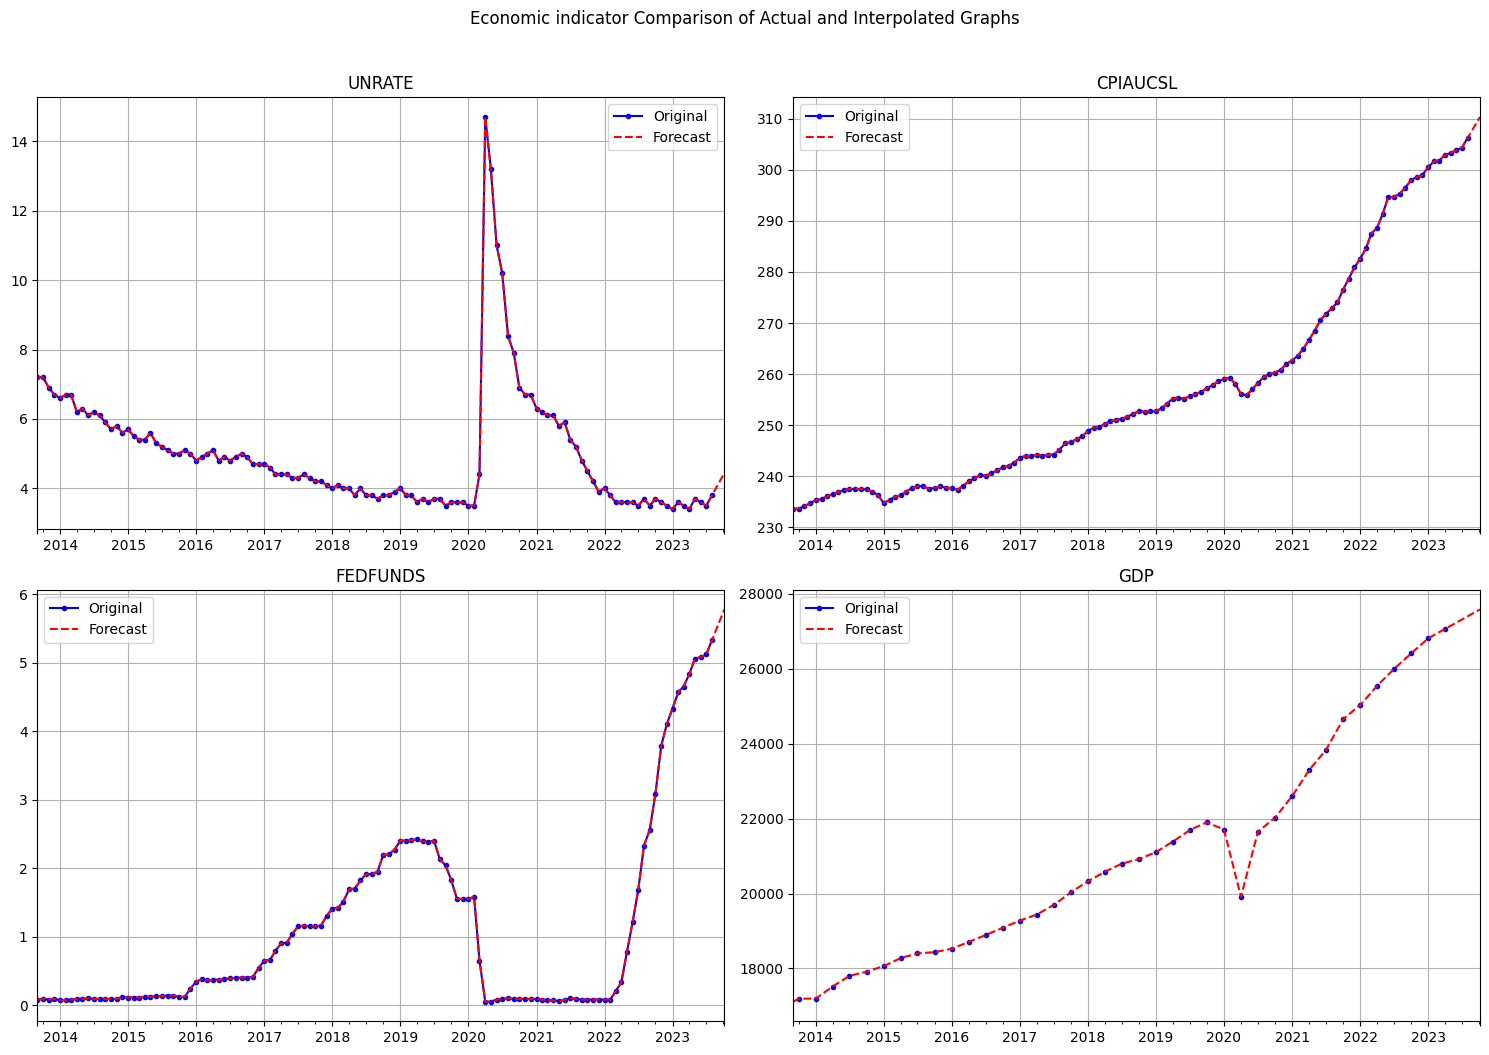

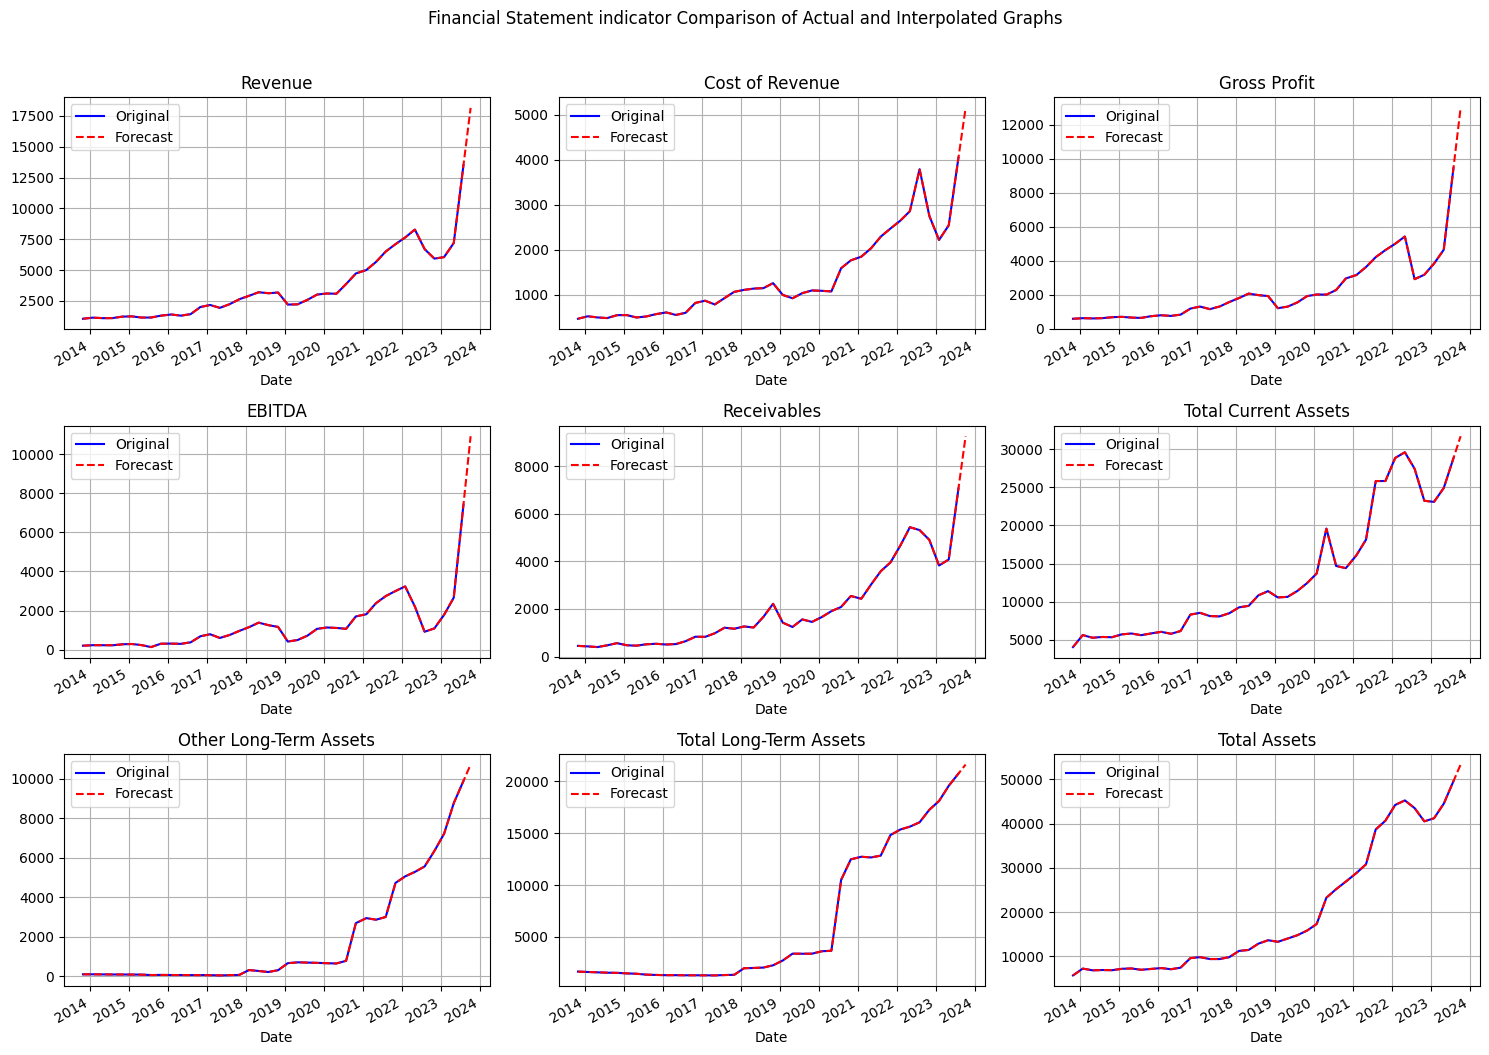

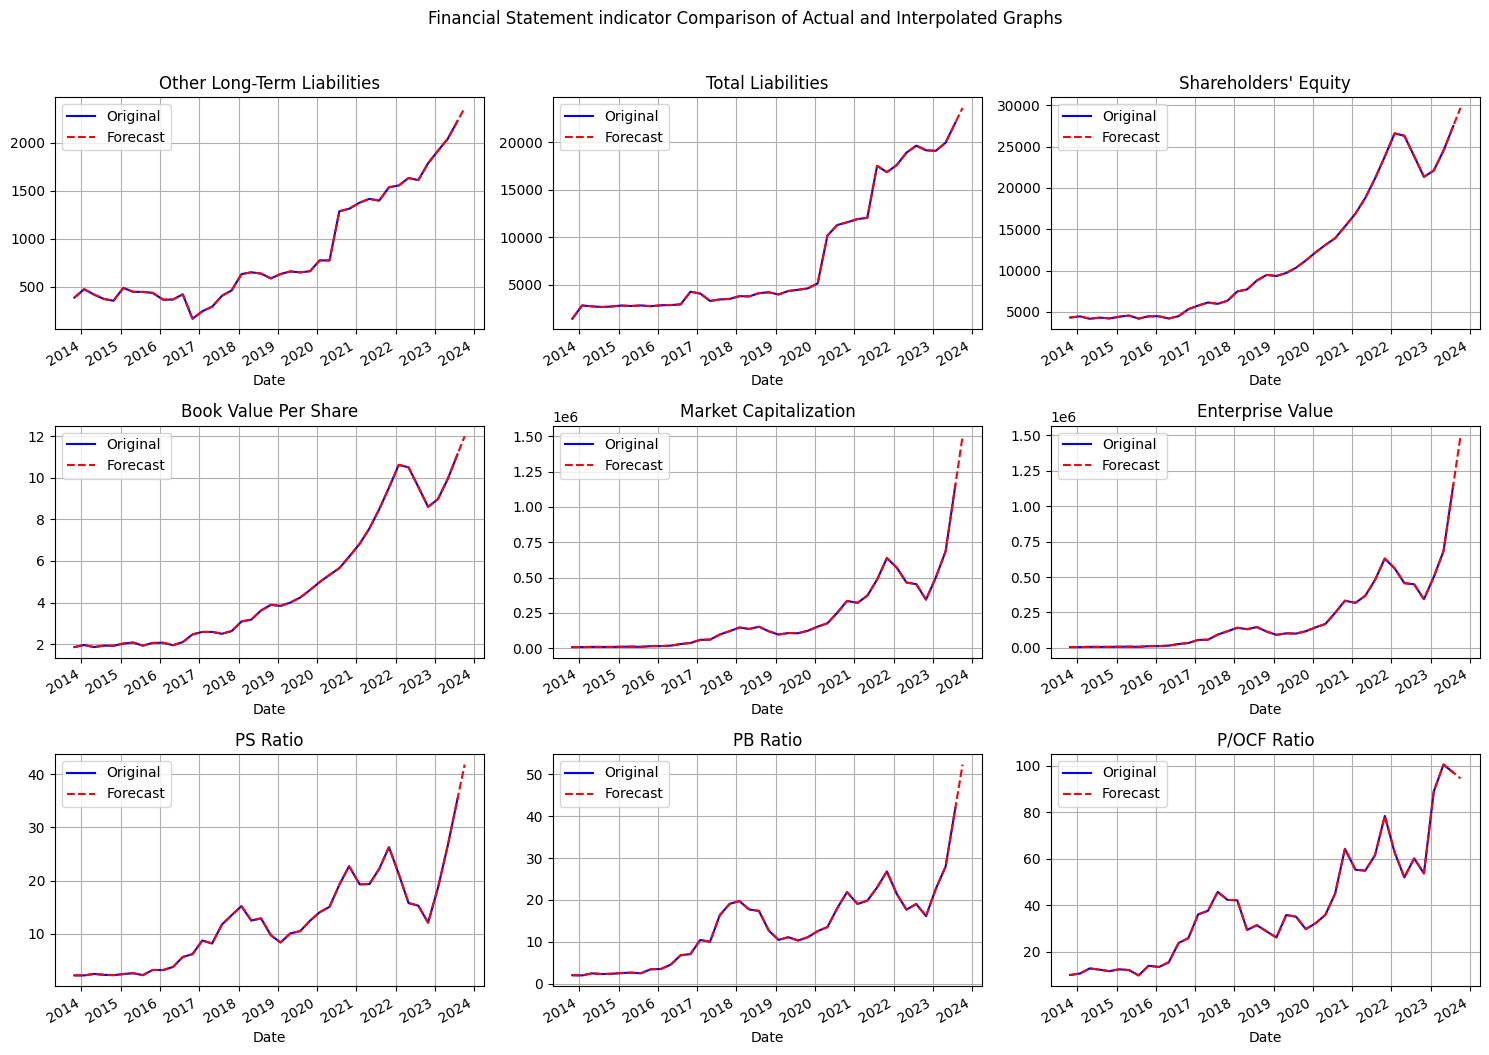

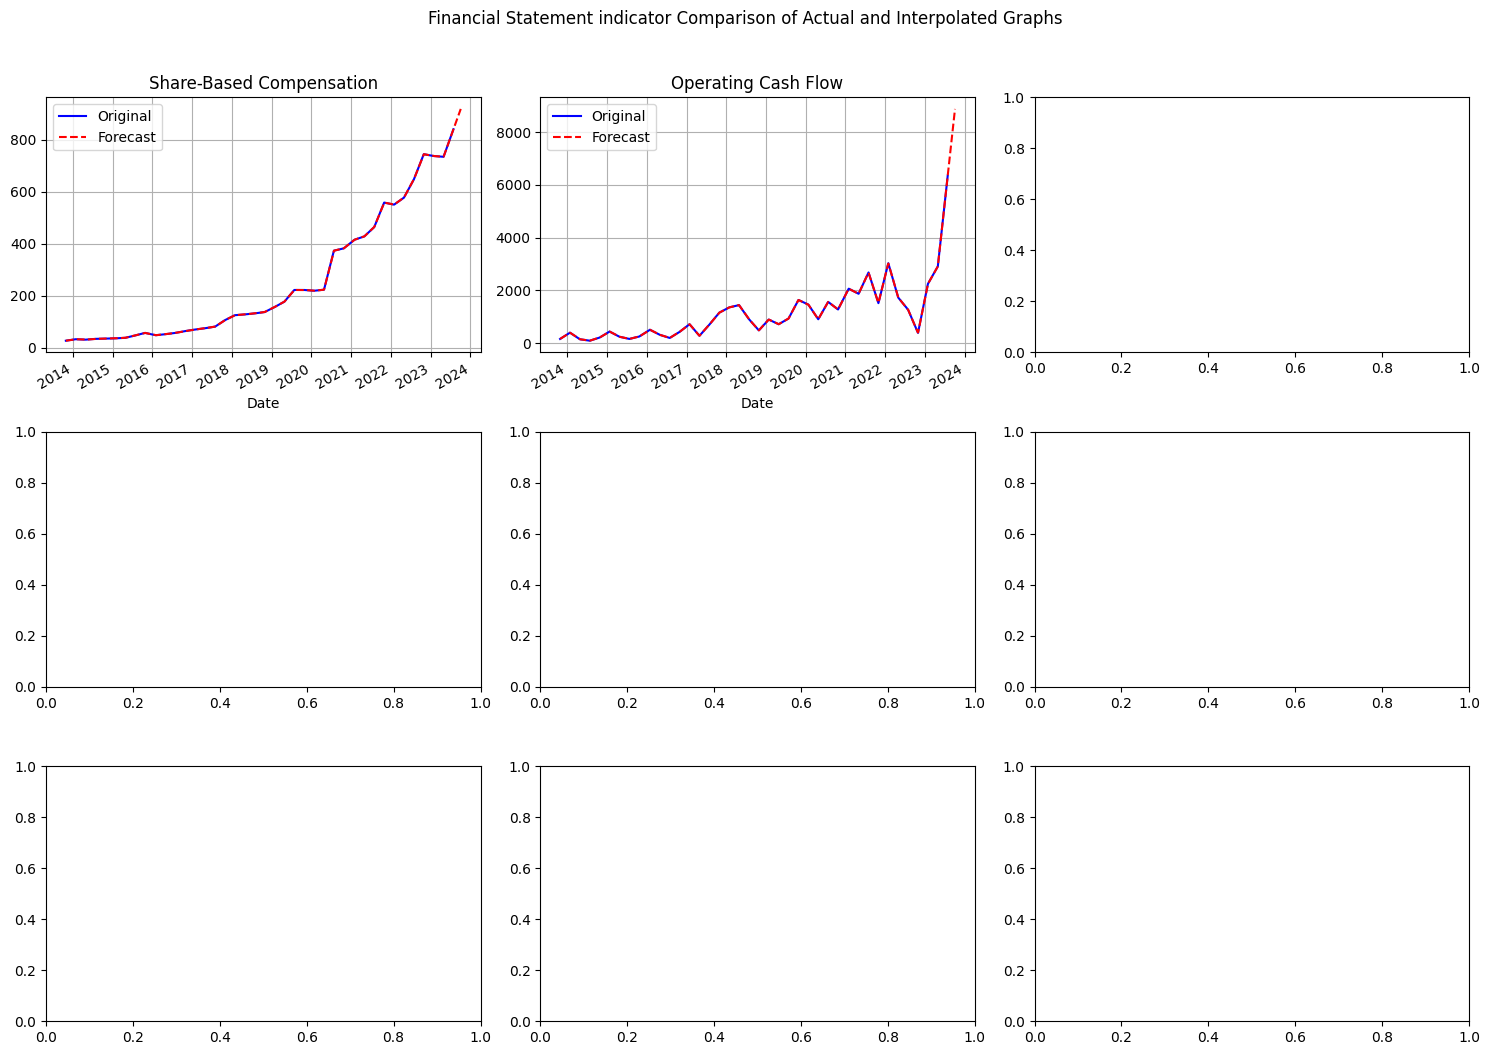

In [9]:
# 1. Economic Indicators plot comparison
econ_month_df = Unemployment_Rate.join([CPI, FEDFUNDS, GDP], how='left')
fig, axes = plt.subplots(2, 2, figsize=(15, 10))  
axes = axes.ravel()

for idx, column in enumerate(econ_month_df.columns):
    ax = axes[idx]
    econ_month_df[column].plot(ax=ax, label='Original', linestyle='-', color='blue', marker='o', ms=3)
    daily_econ[column].plot(ax=ax, label='Forecast', linestyle='--', color='red')
    ax.set_title(column)
    ax.legend(loc='best')
    ax.grid(True)
plt.tight_layout()
plt.suptitle('Economic indicator Comparison of Actual and Interpolated Graphs', y=1.05)
plt.show()

# 2. Financial Statement Indicators plot comparison
common_columns = FS_Summary.columns.intersection(daily_FS_Summary.columns)
common_columns
page_size = 9
total_pages = -(-len(common_columns) // page_size)

for page in range(total_pages):
    fig, axes = plt.subplots(3, 3, figsize=(15, 10))
    axes = axes.ravel() 
    end_idx = min((page + 1) * page_size, len(common_columns))    
    for idx in range(page * page_size, end_idx):
        column = common_columns[idx]
        FS_Summary[column].plot(ax=axes[idx % page_size], label='Original', linestyle='-', color='blue')
        daily_FS_Summary[column].plot(ax=axes[idx % page_size], label='Forecast', linestyle='--', color='red')
        axes[idx % page_size].set_title(column)
        axes[idx % page_size].legend(loc='best')
        axes[idx % page_size].grid(True)
    plt.tight_layout()
    plt.suptitle('Financial Statement indicator Comparison of Actual and Interpolated Graphs', y=1.05)
    plt.show()


# 5. 변수들과 수정종가간의 상관관계 시각화 및 변수 선택

['Open', 'High', 'Low', 'Close', 'Adj Close', 'MA5', 'MA20', 'MA60', 'MA120', 'EMA5', 'EMA20', 'EMA60', 'EMA120', 'BOL_AVG', 'BOL_H1', 'BOL_L1', 'BOL_H2', 'BOL_L2']


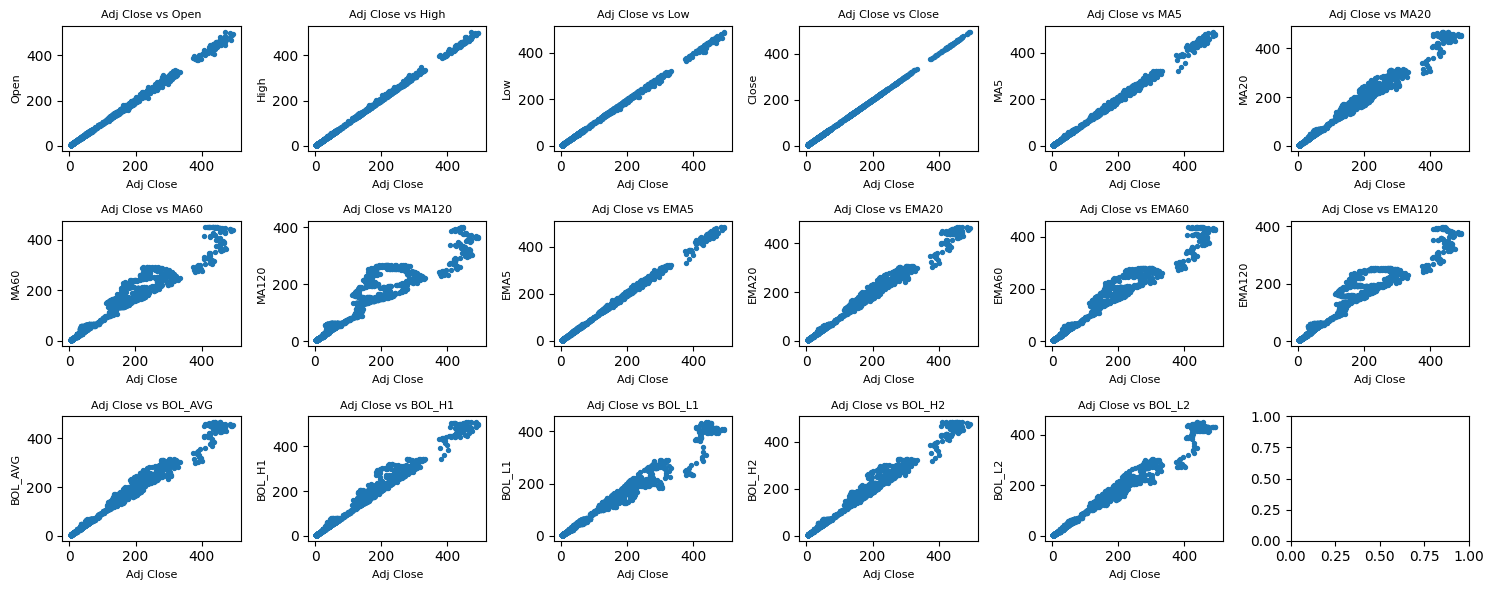

['Adj Close', 'CPIAUCSL', 'GDP']


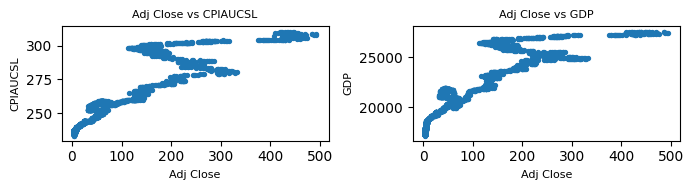

['Adj Close', 'Information Technology Adj Close']


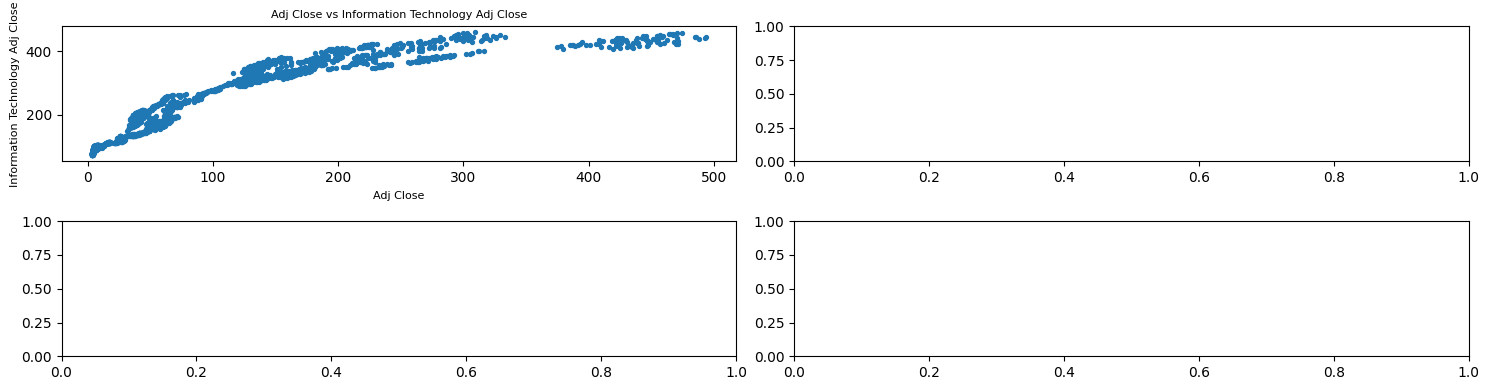

['Revenue', 'Cost of Revenue', 'Gross Profit', 'EBITDA', 'Receivables', 'Total Current Assets', 'Other Long-Term Assets', 'Total Long-Term Assets', 'Total Assets', 'Other Long-Term Liabilities', 'Total Liabilities', "Shareholders' Equity", 'Book Value Per Share', 'Market Capitalization', 'Enterprise Value', 'PS Ratio', 'PB Ratio', 'P/OCF Ratio', 'Share-Based Compensation', 'Operating Cash Flow', 'Adj Close']


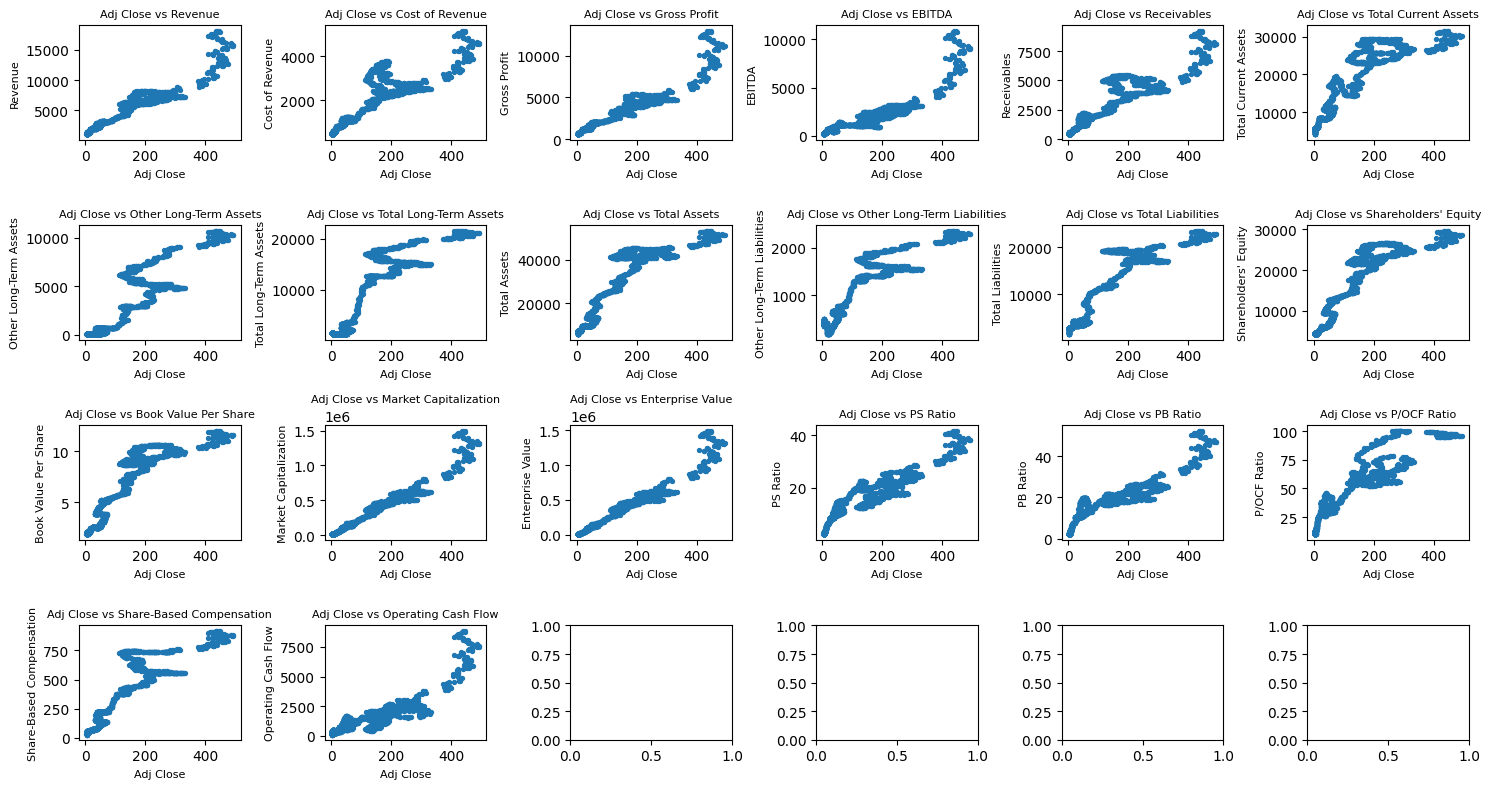

In [10]:
### Technical Feature Selection

# 1.1. Filter features with a correlation coefficient of 0.9 or higher
correlation = stock_df.corr()['Adj Close']
selected_features = correlation[correlation.abs() > 0.9].index.tolist() 
selected_features2 = selected_features.copy()
selected_features2.remove('Adj Close')
print(selected_features) 

# 1.2. Correlation Graph against Adj Close
ncols = 6  
nrows = 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 2*nrows))
for ax, feature in zip(axes.ravel(), selected_features2):
    ax.scatter(stock_df['Adj Close'], stock_df[feature], s=8) 
    ax.set_title(f'Adj Close vs {feature}', fontsize=8)
    ax.set_xlabel('Adj Close', fontsize=8)
    ax.set_ylabel(feature, fontsize=8)
plt.tight_layout()
plt.show()

# 1.3. Select features based on high correlation
tech_df = stock_df[selected_features]


### Fundamental Feature Selection

## Economic Variable Selection
# 2.1. Filter features with a correlation coefficient of 0.8 or higher
correlation = econ_df.corr()['Adj Close']
selected_features = correlation[correlation.abs() > 0.8].index.tolist() 
selected_features2 = selected_features.copy()
selected_features2.remove('Adj Close')
print(selected_features) 

# 2.2. Correlation Graph against Adj Close
ncols = 2  
nrows = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(7, 2*nrows))
for ax, feature in zip(axes.ravel(), selected_features2):
    ax.scatter(econ_df['Adj Close'], econ_df[feature], s=8) 
    ax.set_title(f'Adj Close vs {feature}', fontsize=8)
    ax.set_xlabel('Adj Close', fontsize=8)
    ax.set_ylabel(feature, fontsize=8)
plt.tight_layout()
plt.show()

# 2.3. Select features based on high correlation
econ_df = econ_df[selected_features]

## Industry Variable Selection
# 3.1. Filter features with a correlation coefficient of 0.9 or higher
correlation = Industry_df.corr()['Adj Close']
selected_features = correlation[correlation.abs() > 0.9].index.tolist() 
selected_features2 = selected_features.copy()
selected_features2.remove('Adj Close')
print(selected_features) 

# 3.2.
ncols = 2  
nrows = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 2*nrows))
for ax, feature in zip(axes.ravel(), selected_features2):
    ax.scatter(Industry_df['Adj Close'], Industry_df[feature], s=8) 
    ax.set_title(f'Adj Close vs {feature}', fontsize=8)
    ax.set_xlabel('Adj Close', fontsize=8)
    ax.set_ylabel(feature, fontsize=8)
plt.tight_layout()
plt.show()

# 3.3. Select features based on high correlation
Industry_df = Industry_df[selected_features]

## Company Variable Selection
# 4.1. Filter features with a correlation coefficient of 0.9 or higher
correlation = daily_FS_Summary.corr()['Adj Close']
selected_features = correlation[correlation.abs() > 0.9].index.tolist() 
selected_features2 = selected_features.copy()
selected_features2.remove('Adj Close')
print(selected_features) 

# 4.2.
ncols = 6  
nrows = 4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 2*nrows))
for ax, feature in zip(axes.ravel(), selected_features2):
    ax.scatter(daily_FS_Summary['Adj Close'], daily_FS_Summary[feature], s=8) 
    ax.set_title(f'Adj Close vs {feature}', fontsize=8)
    ax.set_xlabel('Adj Close', fontsize=8)
    ax.set_ylabel(feature, fontsize=8)
plt.tight_layout()
plt.show()

# 주가예측 분석

# 1. Technical Analysis - LSTM model

In [14]:
## 1.1. Load data and Remove Missing value
df = tech_df

df = df.dropna()
df.isnull().sum() 

## 1.2. Apply MinMax Normalization
scaler = MinMaxScaler()
scale_cols = df.columns.tolist()
scaled_df = scaler.fit_transform(df[scale_cols])
scaled_df = pd.DataFrame(scaled_df, columns=scale_cols) 

# Define Input Parameter: feature, label -> numpy type
def make_sequene_dataset(feature, label, window_size):
    feature_list = []      
    label_list = []        
    for i in range(len(feature)-window_size):
        feature_list.append(feature[i:i+window_size]) 
        label_list.append(label[i+window_size]) 
    return np.array(feature_list), np.array(label_list) 

# Create feature_df, label_df 
feature_cols = df.columns.drop('Adj Close').tolist()
label_cols = [ 'Adj Close' ]

feature_df = pd.DataFrame(scaled_df, columns=feature_cols)
label_df = pd.DataFrame(scaled_df, columns=label_cols)

# DataFrame -> Numpy transform
feature_np = feature_df.to_numpy()
label_np = label_df.to_numpy()

print(f'feature_np.shape:{feature_np.shape}')
print(f'label_np.shape:{label_np.shape}')

feature_np.shape:(2403, 17)
label_np.shape:(2403, 1)


In [15]:
## 1.3. Create data    
# Set window size
window_size = 30
X, Y = make_sequene_dataset(feature_np, label_np, window_size)

# 3.2. Split into train, test (8:2)
split = int(len(X)*0.80) 
x_train = X[0:split]
y_train = Y[0:split]

x_test = X[split:]
y_test = Y[split:]

print(f'X.shape:{X.shape}, Y.shape:{Y.shape}')
print(f'x_train.shape:{x_train.shape}, y_train.shape:{y_train.shape}')
print(f'x_test.shape:{x_test.shape}, y_test.shape:{y_test.shape}') 


X.shape:(2373, 30, 17), Y.shape:(2373, 1)
x_train.shape:(1898, 30, 17), y_train.shape:(1898, 1)
x_test.shape:(475, 30, 17), y_test.shape:(475, 1)


In [16]:
## 1.4. Construct and Compile model
model = Sequential()

model.add(LSTM(64, activation='tanh', input_shape=x_train[0].shape, return_sequences=False, 
               kernel_regularizer=L1L2(l1=0.0001, l2=0.0001), recurrent_regularizer=L1L2(l1=0.0001, l2=0.0001)))
model.add(Dropout(0.2))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='adam', metrics=['mae'])

model.summary()

# List to record the loss values during the model training process
train_loss_history = []
val_loss_history = []

# Train model (Apply earlystopping)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

hist = model.fit(x_train, y_train, 
          validation_data=(x_test, y_test),
          epochs=1000, batch_size=150,       
          callbacks=[early_stop]) 

pred = model.predict(x_test)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                20992     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 21057 (82.25 KB)
Trainable params: 21057 (82.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/1000
13/13 [==============================] - 1s 33ms/step - loss: 0.1192 - mae: 0.0376 - val_loss: 0.1247 - val_mae: 0.1077
Epoch 2/1000
13/13 [==============================] - 0s 18ms/step - loss: 0.0970 - mae: 0.0208 - val_loss: 0.0939 - val_mae: 0.0755
Epoch 3/1000
13/13

## 1.2. Technical model Accuracy test

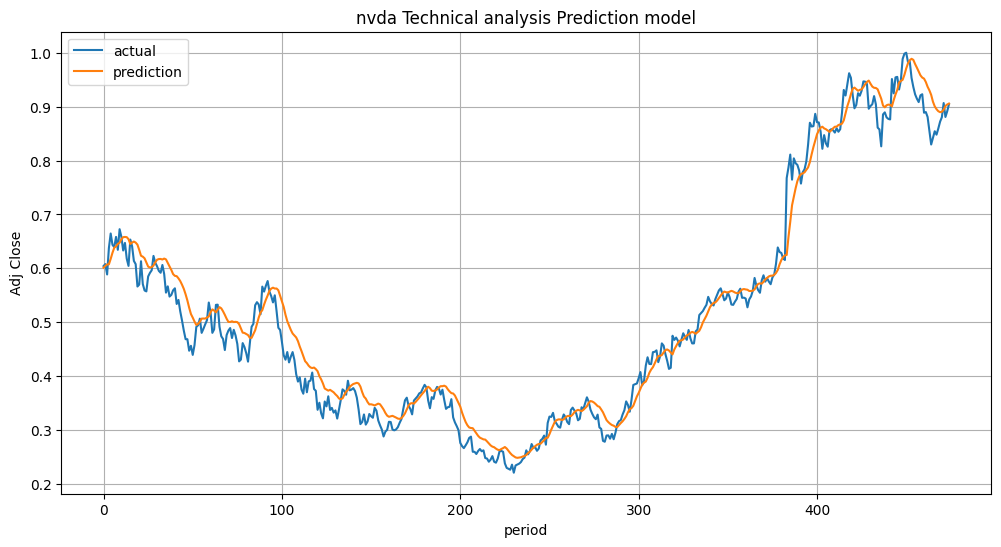

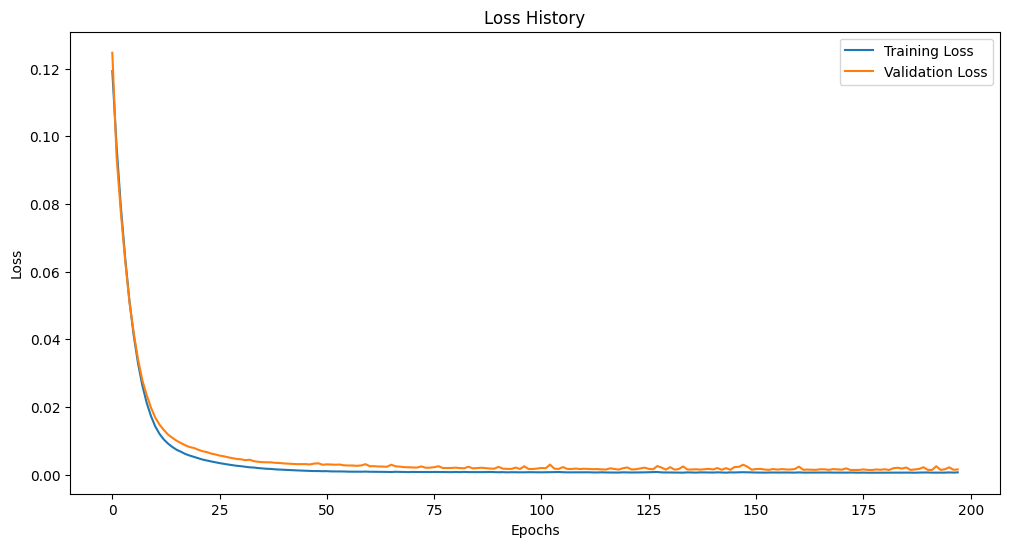

  Metrics    Values
0    MAPE  0.058101
1     MAE  0.026159
2    RMSE  0.034073


In [17]:
# Evaluation 1: Prediction Graph
plt.figure(figsize=(12, 6))
plt.title(f'{ticker} Technical analysis Prediction model')
plt.ylabel('Adj Close')
plt.xlabel('period')
plt.plot(y_test, label='actual')
plt.plot(pred, label='prediction')
plt.grid()
plt.legend(loc='best')
plt.show()

# Evaluation 2: Learning Curve
train_loss_history.extend(hist.history['loss']) 
val_loss_history.extend(hist.history['val_loss'])

plt.figure(figsize=(12, 6))
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.legend()
plt.title('Loss History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Evaluation 2: MAPE, MAE, RMSE
mape = np.sum(abs(y_test - pred) / y_test) / len(x_test)
mae = np.mean(np.abs(y_test - pred))
rmse = np.sqrt(np.mean(np.square(y_test - pred)))

metrics_df = pd.DataFrame({
    'Metrics': ['MAPE', 'MAE', 'RMSE'],
    'Values': [mape, mae, rmse]})

print(metrics_df)

## 1.3. DataFrame for use as input to the Stacking model

In [18]:
inverse_df = pd.DataFrame(np.zeros((len(y_test), len(scale_cols))), columns=scale_cols) 
inverse_df['Adj Close'] = y_test.flatten()
real_y_test = scaler.inverse_transform(inverse_df)[:, inverse_df.columns.get_loc('Adj Close')]

inverse_df['Adj Close'] = pred.flatten() 
real_pred = scaler.inverse_transform(inverse_df)[:, inverse_df.columns.get_loc('Adj Close')]

dates = df.index[split+window_size:].values 

tech_result_df = pd.DataFrame({
    'Date': dates,
    'Real Price': real_y_test,
    'Predicted Price': real_pred
})

## 1.4. Predicting the actual next day's adjusted closing price based on the Technical model

In [19]:
last_date = pd.to_datetime(df.index[-1]) 

if last_date.weekday() == 4:  
    next_day = last_date + pd.Timedelta(days=3)  
else:
    next_day = last_date + pd.Timedelta(days=1)  

# 1. Extract the last 30 days data
recent_feature = feature_np[-window_size:]
recent_feature = recent_feature.reshape(1, window_size, -1)

# 2. Predict the value for the next day
predicted_new = model.predict(recent_feature)

# 3. Inverse transform the predicted value to its original scale
dummy_data = np.zeros((1, scaled_df.shape[1] - 1))
predicted_new_full_features = np.hstack([predicted_new, dummy_data])

tech_predicted_new_original = scaler.inverse_transform(predicted_new_full_features)[0, 0]

1/1 [==============================] - 0s 12ms/step


# 2. Fundamental Analysis - LSTM model

In [21]:
## 2.1. Load data
df = econ_df
df2 = Industry_df
df3 = daily_FS_Summary

df = df.merge(df2, on='Date', how='left')
df = df.merge(df3, on='Date', how='left')

df = df.dropna()
df.isnull().sum() 

## 2.2. Apply MinMax Normalization
scaler = MinMaxScaler()
scale_cols = df.columns.tolist()
scaled_df = scaler.fit_transform(df[scale_cols])
scaled_df = pd.DataFrame(scaled_df, columns=scale_cols) 

# Define Input Parameter: feature, label -> numpy type
def make_sequene_dataset(feature, label, window_size):
    feature_list = []      
    label_list = []        
    for i in range(len(feature)-window_size):
        feature_list.append(feature[i:i+window_size]) 
        label_list.append(label[i+window_size]) 
    return np.array(feature_list), np.array(label_list) 

# feature_df, label_df 생성
feature_cols = df.columns.drop('Adj Close').tolist()
label_cols = [ 'Adj Close' ]

feature_df = pd.DataFrame(scaled_df, columns=feature_cols)
label_df = pd.DataFrame(scaled_df, columns=label_cols)

# DataFrame -> Numpy transformation
feature_np = feature_df.to_numpy()
label_np = label_df.to_numpy()

print(f'feature_np.shape:{feature_np.shape}')
print(f'label_np.shape:{label_np.shape}')

feature_np.shape:(2502, 25)
label_np.shape:(2502, 1)


In [22]:
## 2.3. Create data    
# Set window size
window_size = 30
X, Y = make_sequene_dataset(feature_np, label_np, window_size)


# 3.2. Split into train, test (8:2)
split = int(len(X)*0.80) 
x_train = X[0:split]
y_train = Y[0:split]

x_test = X[split:]
y_test = Y[split:]

print(f'X.shape:{X.shape}, Y.shape:{Y.shape}')
print(f'x_train.shape:{x_train.shape}, y_train.shape:{y_train.shape}')
print(f'x_test.shape:{x_test.shape}, y_test.shape:{y_test.shape}') 

X.shape:(2472, 30, 25), Y.shape:(2472, 1)
x_train.shape:(1977, 30, 25), y_train.shape:(1977, 1)
x_test.shape:(495, 30, 25), y_test.shape:(495, 1)


In [23]:
## 2.4. Construct and Compile model
model = Sequential()

model.add(LSTM(128, activation='tanh', input_shape=x_train[0].shape, return_sequences=True,
               kernel_regularizer=L1L2(l1=0.001, l2=0.001), recurrent_regularizer=L1L2(l1=0.001, l2=0.001)))
               
model.add(Dropout(0.2))

model.add(LSTM(64, activation='tanh'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='adam', metrics=['mae'])

model.summary()

# List to record the loss values during the model training process
train_loss_history = []
val_loss_history = []

# Train model (Apply earlystopping)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

hist = model.fit(x_train, y_train, 
          validation_data=(x_test, y_test),
          epochs=1000, batch_size=150,       
          callbacks=[early_stop]) 

pred = model.predict(x_test)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 30, 128)           78848     
                                                                 
 dropout_1 (Dropout)         (None, 30, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 128321 (501.25 KB)
Trainable params: 128321 (501.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/1000
1

## 2.2. Fundamental model Accuracy test

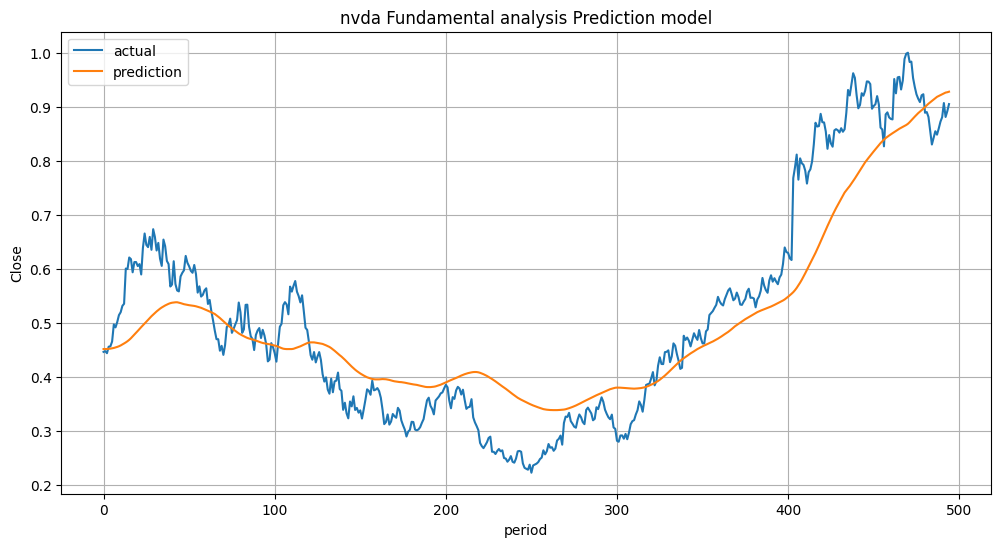

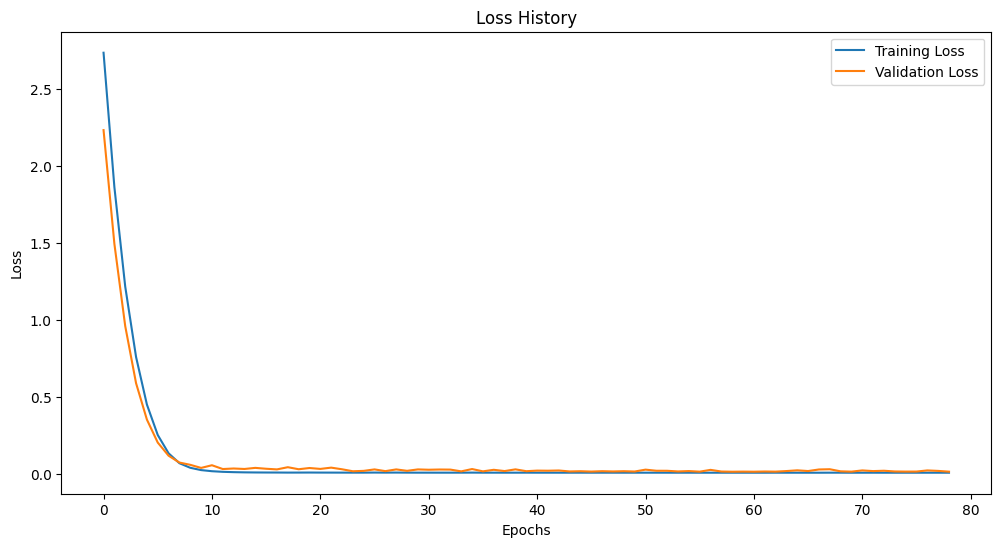

  Metrics    Values
0    MAPE  0.149165
1     MAE  0.068045
2    RMSE  0.084641


In [24]:
# Evaluation 1: Prediction Graph
plt.figure(figsize=(12, 6))
plt.title(f'{ticker} Fundamental analysis Prediction model')
plt.ylabel('Close')
plt.xlabel('period')
plt.plot(y_test, label='actual')
plt.plot(pred, label='prediction')
plt.grid()
plt.legend(loc='best')
plt.show()


# Evaluation 2: Learning Curve
train_loss_history.extend(hist.history['loss']) 
val_loss_history.extend(hist.history['val_loss'])

plt.figure(figsize=(12, 6))
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.legend()
plt.title('Loss History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


# Evaluation 3: MAPE, MAE, RMSE
mape = np.sum(abs(y_test - pred) / y_test) / len(x_test)
mae = np.mean(np.abs(y_test - pred))
rmse = np.sqrt(np.mean(np.square(y_test - pred)))

metrics_df = pd.DataFrame({
    'Metrics': ['MAPE', 'MAE', 'RMSE'],
    'Values': [mape, mae, rmse]})

print(metrics_df)

## 2.3. DataFrame for use as input to the Stacking model

In [25]:
inverse_df = pd.DataFrame(np.zeros((len(y_test), len(scale_cols))), columns=scale_cols) 
inverse_df['Adj Close'] = y_test.flatten()
real_y_test = scaler.inverse_transform(inverse_df)[:, inverse_df.columns.get_loc('Adj Close')]

inverse_df['Adj Close'] = pred.flatten() 
real_pred = scaler.inverse_transform(inverse_df)[:, inverse_df.columns.get_loc('Adj Close')]

dates = df.index[split+window_size:].values 

fund_result_df = pd.DataFrame({
    'Date': dates,
    'Real Price': real_y_test,
    'Predicted Price': real_pred
})

## 2.4. Predicting the actual next day's adjusted closing price based on the Technical model

In [26]:
last_date = pd.to_datetime(df.index[-1]) 

if last_date.weekday() == 4:  
    next_day = last_date + pd.Timedelta(days=3) 
else:
    next_day = last_date + pd.Timedelta(days=1) 

# 1. Extract the last 50 days data
latest_data = feature_np[-window_size:]
latest_data = latest_data.reshape(1, window_size, -1)

# 2. Predict the value for the next day
next_day_pred = model.predict(latest_data)

# 3. Inverse transform the predicted value to its original scale
inverse_df_temp = pd.DataFrame(np.zeros((1, len(scale_cols))), columns=scale_cols)  
inverse_df_temp['Adj Close'] = next_day_pred.flatten()
fund_predicted_new_original = scaler.inverse_transform(inverse_df_temp)[:, inverse_df_temp.columns.get_loc('Adj Close')]

# Convert numpy array value to scalar
fund_predicted_new_original = fund_predicted_new_original.item()

1/1 [==============================] - 0s 17ms/step


# 3. 최종예측을 위한 Stacking model 생성 (XGBoost, GridSearchCV)

## 3.1. 데이터 준비 및 전처리

In [27]:
# 1. Create dataframe based on each analysis result
df = pd.merge(tech_result_df[['Date', 'Real Price', 'Predicted Price']], 
                     fund_result_df[['Date', 'Predicted Price']],
                     on='Date', 
                     how='inner', 
                     suffixes=('_Tech', '_Fund'))

df.columns = ['Date', 'Real Price', 'Tech_Pred', 'Fund_Pred'] # Rename Column
df = df.set_index('Date').sort_index()

# 2. Apply MinMax Normalization
scaler = MinMaxScaler()
scale_cols = ['Real Price', 'Tech_Pred', 'Fund_Pred']
scaled_df = scaler.fit_transform(df[scale_cols])
scaled_df = pd.DataFrame(scaled_df, columns=scale_cols) 

# Create Feature/Label for Stacking model
X_stack = scaled_df[['Tech_Pred', 'Fund_Pred']].values
y_stack = scaled_df['Real Price'].values

# 3. Data split (20% test)
X_train, X_val, y_train, y_val = train_test_split(X_stack, y_stack, test_size=0.2, random_state=42)

print(f'X_train.shape:{X_train.shape}, X_val.shape:{X_val.shape}')
print(f'y_train.shape:{y_train.shape}, y_val.shape:{y_val.shape}') 


X_train.shape:(380, 2), X_val.shape:(95, 2)
y_train.shape:(380,), y_val.shape:(95,)


In [28]:
# 4. Meta model training using XGBoost with GridSearchCV
model = xgb.XGBRegressor(objective='reg:squarederror')

param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9],
    'n_estimators': [50, 100],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 5, 10],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0.5, 1, 1.5]
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Best parameters found: {best_params}")

# Train the model with best parameters
meta_model_xgb = xgb.XGBRegressor(objective='reg:squarederror', **best_params)
meta_model_xgb.fit(X_train, y_train)

y_pred = meta_model_xgb.predict(X_val)


Best parameters found: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1.5, 'subsample': 0.9}


## 3.2. Meta model result visualization

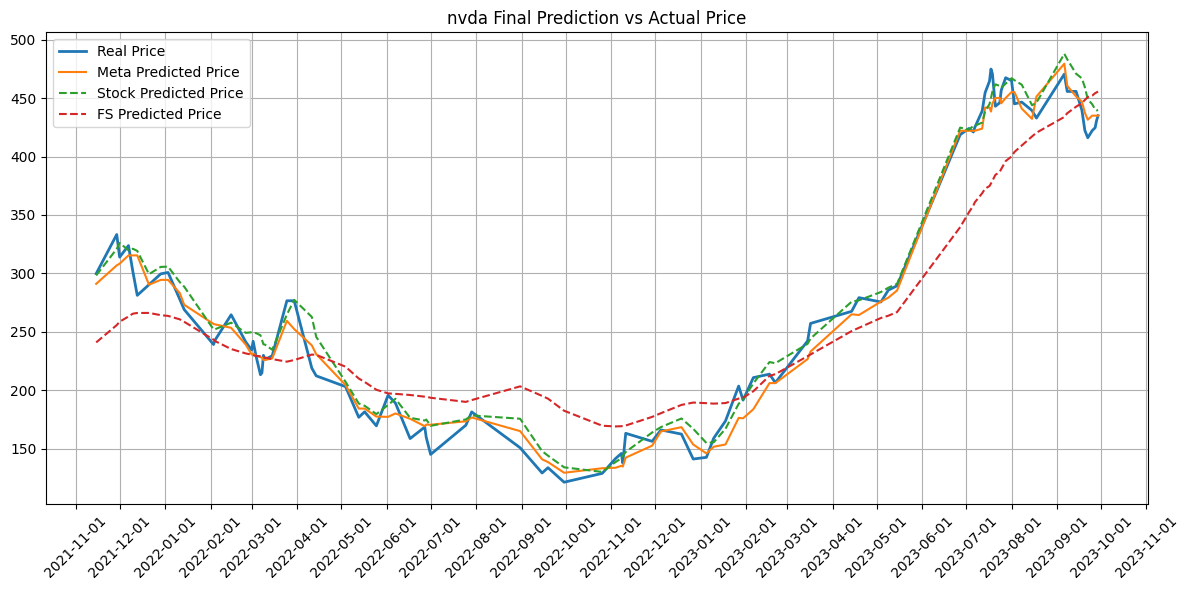

In [29]:
# Extracting predicted values from scaled data
y_val_original = scaler.inverse_transform(np.column_stack([y_val, np.zeros_like(y_val), np.zeros_like(y_val)]))[:, 0]
y_pred_original = scaler.inverse_transform(np.column_stack([y_pred, np.zeros_like(y_pred), np.zeros_like(y_pred)]))[:, 0]
tech_pred_original = scaler.inverse_transform(np.column_stack([np.zeros_like(y_pred), X_val[:, 0], np.zeros_like(y_pred)]))[:, 1]
fund_pred_original = scaler.inverse_transform(np.column_stack([np.zeros_like(y_pred), np.zeros_like(y_pred), X_val[:, 1]]))[:, 2]

# Extracting date index
date_train, date_val = train_test_split(df.index, test_size=0.2, random_state=42)

# Prediction Graph
plot_df = pd.DataFrame({
    'Date': date_val,
    'Real Price': y_val_original,
    'Meta Predicted Price': y_pred_original,
    'Stock Predicted Price': tech_pred_original,
    'FS Predicted Price': fund_pred_original
})

plot_df = plot_df.sort_values(by='Date')
plot_df['Date'] = pd.to_datetime(plot_df['Date'])

plt.figure(figsize=(12, 6))
plt.plot(plot_df['Date'], plot_df['Real Price'], label='Real Price', linewidth=2)
plt.plot(plot_df['Date'], plot_df['Meta Predicted Price'], label='Meta Predicted Price', linewidth=1.5)
plt.plot(plot_df['Date'], plot_df['Stock Predicted Price'], '--', label='Stock Predicted Price', linewidth=1.5)
plt.plot(plot_df['Date'], plot_df['FS Predicted Price'], '--', label='FS Predicted Price', linewidth=1.5)

ax = plt.gca() 
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1)) 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  

plt.title(f"{ticker} Final Prediction vs Actual Price")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  
plt.tight_layout()  


## 3.3. Meta model Accuracy Test

train_mse: 0.0009957430113720694, val_mse: 0.0011798934267813381


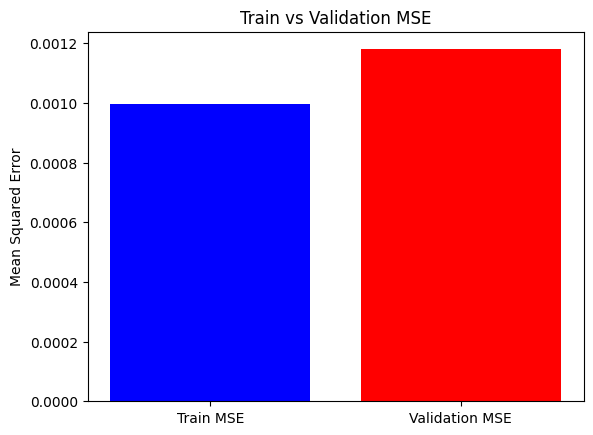

val_mse: 0.0011798934267813381, cross_val_mse: 0.005648123540495079


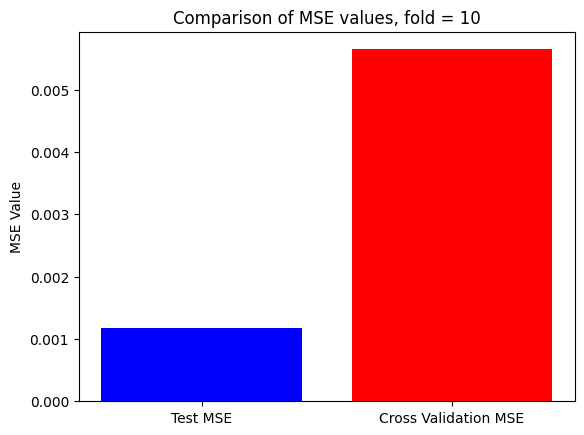

In [30]:
# 1. MSE Comparison Graph for train and validation set
y_train_pred = meta_model_xgb.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
val_mse = mean_squared_error(y_val, y_pred)
print( f'train_mse: {train_mse}, val_mse: {val_mse}')

plt.bar(['Train MSE', 'Validation MSE'], [train_mse, val_mse], color=['blue', 'red'])
plt.ylabel('Mean Squared Error')
plt.title('Train vs Validation MSE')
plt.show()

# 2.  MSE Comparison Graph using cross validation for validation and cv validation (fold =10)
cross_val_mse = -cross_val_score(meta_model_xgb, X_stack, y_stack, cv=10, scoring='neg_mean_squared_error').mean()
errors = [val_mse, cross_val_mse]
labels = ['Test MSE', 'Cross Validation MSE']
print( f'val_mse: {val_mse}, cross_val_mse: {cross_val_mse}')

plt.bar(labels, errors, color=['blue', 'red'])
plt.ylabel('MSE Value')
plt.title('Comparison of MSE values, fold = 10')
plt.show()

## 3.4. Predicting the actual price for the next day

In [31]:
# Predicted values for the next day obtained from the Technical and Fundamental models
next_day_tech_pred = tech_predicted_new_original  
next_day_fund_pred = fund_predicted_new_original 

next_day_tech_pred_scaled = scaler.transform([[0, next_day_tech_pred, 0]])[0][1]  
next_day_fund_pred_scaled = scaler.transform([[0, 0, next_day_fund_pred]])[0][2]  

# Predict with trained stacking model
next_day_meta_pred_scaled = meta_model_xgb.predict(np.array([[next_day_tech_pred_scaled, next_day_fund_pred_scaled]]))[0]
next_day_meta_pred = scaler.inverse_transform([[next_day_meta_pred_scaled, 0, 0]])[0][0]

# Print the date of the next day
last_date = pd.to_datetime(df.index[-1]) 

if last_date.weekday() == 4: 
    next_day = last_date + pd.Timedelta(days=3) 
else:
    next_day = last_date + pd.Timedelta(days=1)  

print(f"다음 날({next_day.strftime('%Y-%m-%d')})의 Tech 예측 가격은: {next_day_tech_pred}") 
print(f"다음 날({next_day.strftime('%Y-%m-%d')})의 Funda 예측 가격은: {next_day_fund_pred}") 
print(f"다음 날({next_day.strftime('%Y-%m-%d')})의 최종 예측 가격은: {next_day_meta_pred}") 

다음 날(2023-10-06)의 Tech 예측 가격은: 457.150216189139
다음 날(2023-10-06)의 Funda 예측 가격은: 458.4590757187125
다음 날(2023-10-06)의 최종 예측 가격은: 438.59753871612975
